## Fastai Tweet Analysis
In this project, the Universal Language Model Fine-tuning (ULMFiT) learning method is applied to the US Airlines Twitter comments for sentiment analysis. The model uses the Fastai learning library, whis is built on PyTorch. 

First, we download and import the appropriate modules, and upload the csv file.

In [ ]:
!pip install torch
!pip install fastai2

from fastai2.imports import *
from fastai2.text.all import *

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

We use Pandas to open the csv file containing the tweets.

In [23]:
df = pd.read_csv("Tweets.csv")
df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [24]:
df.shape

(14640, 15)

In [26]:
path = '.'

First we will perform text preprocessing using the Fastai API. We create a language model by passing TextBlock to DataBlock. The text is tokenized and numeralized, then organized into tensors which are split into blocks. Since the language model predicts the last word of a line of text, the independent variable is just the dependend variable offset by one word. 

In [36]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True), get_x=ColReader('text'), splitter=RandomSplitter(0.1)
).dataloaders(df, bs=64)

In [37]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos @usairways what 's going on with passengers diverted to xxup clt on xxup fll to xxup phl flight that left at 830 tonight ? xxbos @united xxup xxunk xxbos @united spoke to someone on your feedback line last night who said she would get me a preferred choice seat for today … xxbos @usairways app is the worst one for airlines . xxmaj ca n't do anything once your original flight,@usairways what 's going on with passengers diverted to xxup clt on xxup fll to xxup phl flight that left at 830 tonight ? xxbos @united xxup xxunk xxbos @united spoke to someone on your feedback line last night who said she would get me a preferred choice seat for today … xxbos @usairways app is the worst one for airlines . xxmaj ca n't do anything once your original flight time
1,"! xxbos @jetblue xxmaj why was flight 669 forced to return to xxup ny when there was a malfunction ? xxmaj why not land in the xxunk air xxunk xxunk xxmaj chi ? xxbos @americanair "" bag has not yet been located "" . xxmaj again , 5th time xxmaj i 've checked it . xxmaj how can tracking my bag be this hard for your system ? xxbos @usairways - xxmaj","xxbos @jetblue xxmaj why was flight 669 forced to return to xxup ny when there was a malfunction ? xxmaj why not land in the xxunk air xxunk xxunk xxmaj chi ? xxbos @americanair "" bag has not yet been located "" . xxmaj again , 5th time xxmaj i 've checked it . xxmaj how can tracking my bag be this hard for your system ? xxbos @usairways - xxmaj i"


We will create the language model using language_model_learner, which will create a RNN using the AWD_LSTM architecture. 

In [38]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

We will use learn.lr_find to find the optimal learning rate. To minimize the loss, we want to choose a learning rate that is about an order of magnitude below the minimum of this plot.

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.03981071710586548)

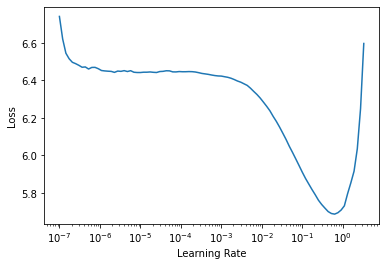

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.308125,3.917775,0.265345,50.288425,00:20


After one epoch, we will repeat the above process.

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=2.75422871709452e-06)

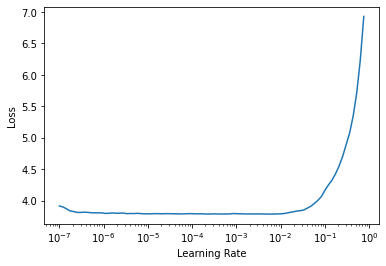

In [43]:
learn.unfreeze()
learn.lr_find()

In [44]:
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.717456,3.796100,0.281838,44.527206,00:20
1,3.620169,3.722039,0.290654,41.348618,00:20
2,3.476951,3.693769,0.293349,40.196041,00:20
3,3.248072,3.715282,0.295446,41.070156,00:20
4,2.970408,3.784290,0.292933,44.004398,00:20
5,2.683792,3.893225,0.290446,49.068901,00:20
6,2.398768,4.033751,0.287580,56.472370,00:20
7,2.180902,4.126079,0.284297,61.934605,00:21
8,2.022858,4.192314,0.283194,66.175720,00:21
9,1.942595,4.211422,0.282172,67.452385,00:20


In [45]:
learn.save_encoder('tuned')

Let's use our tuned language learner model to generate a few sentences. 

In [46]:
TEXT = "This flight was, in my opinion,"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [47]:
print(preds)

['This flight was , in my opinion , will be more likely to never leave my AA account . @united My mom has been stuck in DIA for 3 days and now your airport needs to spread today . i should get a little', "This flight was , in my opinion , on a few minutes less than 48 ! @americanair does n't mean I 'm currently missing a connection due to a delay on US Airways flight . @southwestair Thank you ! @united i"]


Though not perfect, the generated sentences show that the model has learned the syntax of the tweets. 

Now we will move from the language model to the classifier model. We will preprocess the text again, this time with the sentiment as the independent variable. We will pass in the vocab we used for the language model.

In [48]:
dls_clas = TextDataLoaders.from_df(df, path=path, text_vocab=dls_lm.vocab, text_col='text', label_col='airline_sentiment')


In [49]:
dls_clas.show_batch(max_n=3)

,text,category
0,xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . xxmaj i 'm * xxunk xxmaj what is checked bag allowance for xxup jac - lax ?,neutral
1,xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever xxrep 3 ! xxup thank u xxup so xxup much xxrep 6 ! xxpad,positive
2,xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously xxpad xxpad xxpad,negative


We will create a text classifier using text_classifier_learner and import the encoder.

In [50]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [51]:
learn = learn.load_encoder('tuned')

Now to train the classifier, we will use the once cycle method outlined in Fastai's documentation, where we unfreeze one layer at a time. 

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.10000000149011612)

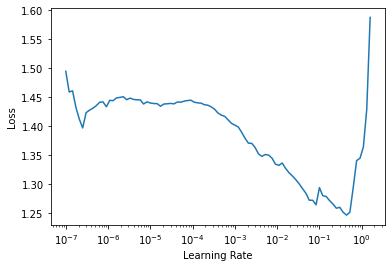

In [52]:
learn.lr_find()

In [53]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.931411,0.559428,0.798497,00:19


In [54]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(8e-3,8e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.638664,0.438523,0.825137,00:20


In [55]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3,5e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.567433,0.435754,0.830601,00:21


In [56]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(5e-3,1e-2))


epoch,train_loss,valid_loss,accuracy,time
0,0.517621,0.439068,0.825137,00:21


Now that our classifier is trained with the encoder from our language model, we can use our model to make predictions. 

In [57]:
learn.predict("I'm not happy")

('negative', tensor(0), tensor([0.4826, 0.2203, 0.2971]))

In [58]:
learn.predict("Good stuff")

('positive', tensor(2), tensor([0.0522, 0.0271, 0.9207]))